## Classifying CIFAR-10 with Data Augmentation

In this exercise, we revisit CIFAR-10 and the networks we previously built.  We will use real-time data augmentation to try to improve our results.

When you are done going through the notebook, experiment with different data augmentation parameters and see if they help (or hurt!) the performance of your classifier.

In [3]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import matplotlib.pyplot as plt
%matplotlib inline

## Testing ImageDataGenerator

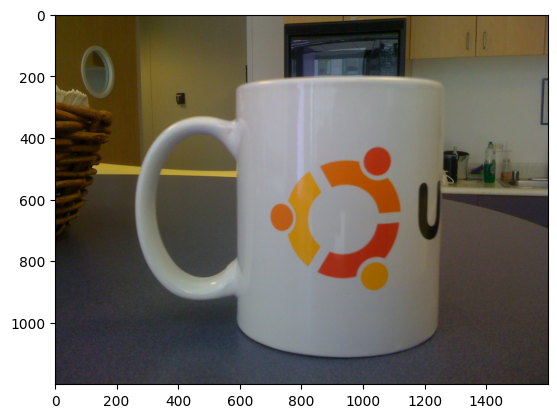

In [4]:
from PIL import Image
import numpy as np

image = Image.open('coffee_mug.jpg')
image = np.expand_dims(image, axis=0).astype('float32')/255
plt.imshow(image[0])

In [5]:
datagen = ImageDataGenerator(
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images

image_generator = datagen.flow(image)

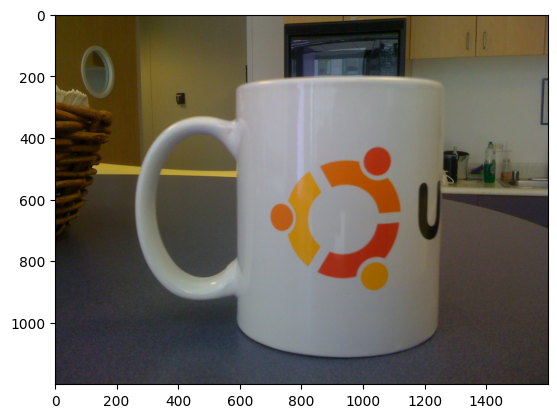

In [6]:
plt.imshow(image_generator.next()[0])

In [7]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [8]:
import numpy as np
import os, random, tensorflow as tf

def set_seed(seed_value=1234):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

set_seed(1234)

## <span style="color:red">Cell ที่เป็นโค้ดหรือคำอธิบายคำตอบ ขอให้สังเกตเห็นได้อย่างชัดเจน</span>

## <span style="color:orange">1. แบ่งข้อมูลออกเป็น train set, val set, และ test set</span>
### * ให้แบ่งข้อมูล val set ออกมาจาก training data โดยให้ใน val set มีข้อมูลของแต่ละคลาสจำนวน 1000 รายการ โดยเป็น 1000 รายการสุดท้ายของแต่ละคลาสที่อยู่ใน training data
### * ให้ปรับโค้ดข้างล่างต่อจากนี้ไปให้ใช้ train set และ val set ในช่วงการเทรน และใช้ test set ในการประเมินประสิทธิภาพของโมเดลที่เทรนได้

In [9]:
num_classes = 10

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [10]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

## <span style="color:orange">2. เปรียบเทียบโมเดลที่มีการใช้ Data Augmentation กับโมเดลที่ไม่ได้ใช้</span>
### * ให้ใช้โครงสร้างของ model_1 ในการตอบคำถามในข้อนี้ โดยห้ามเปลี่ยนแปลงโครงสร้างของโมเดล แต่สามารถปรับเปลี่ยนตัว optimizer และค่า learning rate ได้เท่านั้น
### * ให้เปรียบเทียบและแสดงประสิทธิภาพของโมเดลที่มีการใช้ Data Augmentation กับโมเดลที่ไม่ได้ใช้
### * ให้อธิบายเหตุผลที่ทำได้ผลที่ได้จากโมเดลทั้ง 2 ออกมาเป็นเช่นนั้น

In [11]:
# Let's build a CNN using Keras' Sequential capabilities

model_1 = Sequential()

## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (2,2), padding='same',
                 input_shape=x_train.shape[1:]))
model_1.add(Activation('relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (2,2)))
model_1.add(Activation('relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

## Flatten turns 3x3x32 into 288x1
model_1.add(Flatten())
model_1.add(Dense(512))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes))
model_1.add(Activation('softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        2432      
                                                                 
 activation (Activation)     (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          25632     
                                                                 
 activation_1 (Activation)   (None, 6, 6, 32)          0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 3, 3, 32)          0         
                                                        

We still have 181K parameters, even though this is a "small" model.


In [12]:
batch_size = 32

# initiate RMSprop optimizer
# opt = keras.optimizers.RMSprop(lr=0.0005, decay=1e-6)
opt = keras.optimizers.RMSprop(learning_rate=0.0005)

# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Here we define the `ImageDataGenerator` that we will use to serve images to our model during the training process.  Currently, it is configured to do some shifting and horizontal flipping.

In [13]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
                   
datagen.fit(x_train)      # This computes any statistics that may be needed (e.g. for centering) from the training set.

    
# Fit the model on the batches generated by datagen.flow().
model_1.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
            steps_per_epoch=x_train.shape[0] // batch_size,
            epochs=15,
            validation_data=(x_test, y_test))

Epoch 1/15
1562/1562 [==============================] - 20s 9ms/step - loss: 1.7856 - accuracy: 0.3455 - val_loss: 1.5397 - val_accuracy: 0.4551
Epoch 2/15
1562/1562 [==============================] - 14s 9ms/step - loss: 1.5237 - accuracy: 0.4488 - val_loss: 1.4200 - val_accuracy: 0.4928
Epoch 3/15
1562/1562 [==============================] - 13s 8ms/step - loss: 1.4357 - accuracy: 0.4817 - val_loss: 1.2490 - val_accuracy: 0.5608
Epoch 4/15
1562/1562 [==============================] - 14s 9ms/step - loss: 1.3864 - accuracy: 0.5042 - val_loss: 1.2123 - val_accuracy: 0.5759
Epoch 5/15
1562/1562 [==============================] - 14s 9ms/step - loss: 1.3572 - accuracy: 0.5161 - val_loss: 1.1954 - val_accuracy: 0.5739
Epoch 6/15
1562/1562 [==============================] - 14s 9ms/step - loss: 1.3322 - accuracy: 0.5296 - val_loss: 1.1674 - val_accuracy: 0.5899
Epoch 7/15
1562/1562 [==============================] - 14s 9ms/step - loss: 1.3210 - accuracy: 0.5324 - val_loss: 1.1295 - val_ac

## <span style="color:orange">3. ปรับจูนโมเดลให้ดีขึ้น</span>
### * ให้สร้างโมเดลที่มีความซับซ้อนมากขึ้น โดยใช้ข้อกำหนดดังนี้

    * Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification
    * Use strides of 1 for all convolutional layers.
    
### * ให้เปรียบเทียบและแสดงประสิทธิภาพของโมเดลใหม่นี้ที่มีการใช้ Data Augmentation กับโมเดลที่ไม่ได้ใช้ พร้อมอธิบายเหตุผลที่ทำได้ผลที่ได้จากโมเดลทั้ง 2 ออกมาเป็นเช่นนั้น